In [1]:
run /home/keir/Software/lya_emulator/main.py /share/hypatia/sbird/Lya_Boss /home/keir/Plots/Emulator hires_s8_new /home/keir/Data/emulator


/share/apps/anaconda/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Beginning to initialise LikelihoodClass at 2018-09-06 15:23:35.786820
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e15f3048>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26e42e8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e15ecfd0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af056b4ac88>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af02d50c128>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26e8e80>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26e8f98>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26f4128>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26f4198>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26f4278>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26f4358>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af0e26f4860>
Found spectra in <fake_spectra.spectra.Spectra object 

Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1518>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e15f8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e16d8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e17b8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1898>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1978>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1a58>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1a90>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1b70>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1d30>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1e10>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1ef0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af13f7e1c50>
Found spectra in <fake_spectra.spectra.Spectra obje

Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968ba8>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968b70>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968e10>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968e48>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968f28>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af142968c88>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b860f0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b86240>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b86320>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b86400>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b864e0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b865c0>
Found spectra in <fake_spectra.spectra.Spectra object at 0x2af145b865f8>
Found spectra in <fake_spectra.spectra.Spectra obje

    00s66  0062  -4.634853e+04   5.485043e-03 
Runtime:     00s66
Optimization status: Converged


Name : GP regression
Objective : -46348.533533778595
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  sum.linear.variances     |    0.15712146956918108  |      +ve      |        
  sum.rbf.variance         |     1.9791909001449253  |      +ve      |        
  sum.rbf.lengthscale      |       2.80201221398103  |      +ve      |        
  Gaussian_noise.variance  |  5.283427975433638e-16  |      +ve      |        
  linear.    |  value  |  constraints  |  priors
  variances  |    1.0  |      +ve      |        
  sum.              |  value  |  constraints  |  priors
  linear.variances  |    1.0  |      +ve      |        
  rbf.variance      |    1.0  |      +ve      |        
  rbf.lengthscale   |    1.0  |      +ve      |        
Running L-BFGS-B (Scipy implementation) C

In [ ]:
run /home/keir/Software/lya_emulator/main.py /home/keir/Data/emulator /home/keir/Plots/Emulator hot_cold_training3_rescale_2000 /home/keir/Data/emulator

In [2]:
#import multiprocessing as mu
#import corner as co
#import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
posterior_samples = np.loadtxt('/home/keir/Data/emulator/AA0.97BB1.3_chain_hires_s8_rescale_20000.txt')

In [13]:
n_process = 2
n_parameters = 7
n_marginalised_parameters = 2

#optimisation_bounds_unscaled = np.array([[0.93, 1.04], [1.5e-9, 2.9e-9], [-0.4, 0.4], [0.77, 1.43], [0.66, 0.74]])
optimisation_bounds_unscaled = np.array([[0.96, 1.02], [1.8e-9, 2.7e-9], [-0.2, 0.3], [0.9, 1.4], [0.67, 0.72]])
print(optimisation_bounds_unscaled)
optimisation_bounds_array = np.zeros_like(optimisation_bounds_unscaled)
optimisation_bounds_array[:, 0] = map_to_unit_cube(optimisation_bounds_unscaled[:, 0], output[0].param_limits[n_marginalised_parameters:])
optimisation_bounds_array[:, 1] = map_to_unit_cube(optimisation_bounds_unscaled[:, 1], output[0].param_limits[n_marginalised_parameters:])

#optimisation_bounds_array = np.ones((n_parameters - n_marginalised_parameters, 2))
#optimisation_bounds_array[:, 0] *= 1.e-7
#optimisation_bounds_array[:, 1] *= 1. - 1.e-7

print(optimisation_bounds_array)
optimisation_bounds = [tuple(optimisation_bounds_array[i]) for i in range(n_parameters - n_marginalised_parameters)]
print(optimisation_bounds)

starting_positions = np.array([npr.uniform(low=optimisation_bounds_array[:, 0], high=optimisation_bounds_array[:, 1]) for i in range(n_process)])
#print(starting_positions)


[[ 9.60e-01  1.02e+00]
 [ 1.80e-09  2.70e-09]
 [-2.00e-01  3.00e-01]
 [ 9.00e-01  1.40e+00]
 [ 6.70e-01  7.20e-01]]
[[0.4        0.46666667]
 [0.33333333 0.83333333]
 [0.3        0.8       ]
 [0.4        0.9       ]
 [0.2        0.7       ]]
[(0.39999999999999997, 0.4666666666666667), (0.3333333333333333, 0.8333333333333335), (0.3, 0.8), (0.4, 0.8999999999999999), (0.20000000000000023, 0.6999999999999996)]


In [14]:
import multiprocessing as mg
mg.set_start_method('forkserver', force=True)

import acquisition as ac

#starting_positions = 1.e-7 + npr.rand(n_process, n_parameters - n_marginalised_parameters) * (1. - 2.e-7)
#optimisation_bounds = [(1.e-7, 1. - 1.e-7) for i in range(n_parameters - n_marginalised_parameters)]
#integration_bounds = [list(output[0].param_limits[0]), list(output[0].param_limits[1])]
integration_bounds = [[-0.2, 0.2], [0.85, 1.05]]
argument_list = [(starting_positions[i], output[0], optimisation_bounds, 0.2, 1., integration_bounds) for i in range(n_process)]

pool_instance = mg.Pool(n_process)
optimisation_output = pool_instance.map(ac.optimise_acquisition_function_parallel, argument_list)

[print(map_from_unit_cube(optimisation_output[i].x, output[0].param_limits[n_marginalised_parameters:])) for i in range(n_process)]


[ 1.02e+00  2.70e-09 -2.00e-01  1.40e+00  6.70e-01]
[ 1.02e+00  2.70e-09 -2.00e-01  1.40e+00  6.70e-01]


[None, None]

In [15]:
[print(optimisation_output[i].fun) for i in range(n_process)]

[print(map_from_unit_cube(starting_positions[i], output[0].param_limits[n_marginalised_parameters:])) for i in range(n_process)]

best_process = np.argmin(np.array([optimisation_output[i].fun for i in range(n_process)]))
print(best_process, map_from_unit_cube(optimisation_output[best_process].x, output[0].param_limits[n_marginalised_parameters:]))


43.38047136033414
43.38047136033414
[ 9.77474258e-01  2.49109306e-09 -4.12388067e-02  1.24592192e+00
  6.77452605e-01]
[ 9.64823524e-01  2.39335132e-09 -1.57817556e-01  1.35781343e+00
  6.74526224e-01]
0 [ 1.02e+00  2.70e-09 -2.00e-01  1.40e+00  6.70e-01]


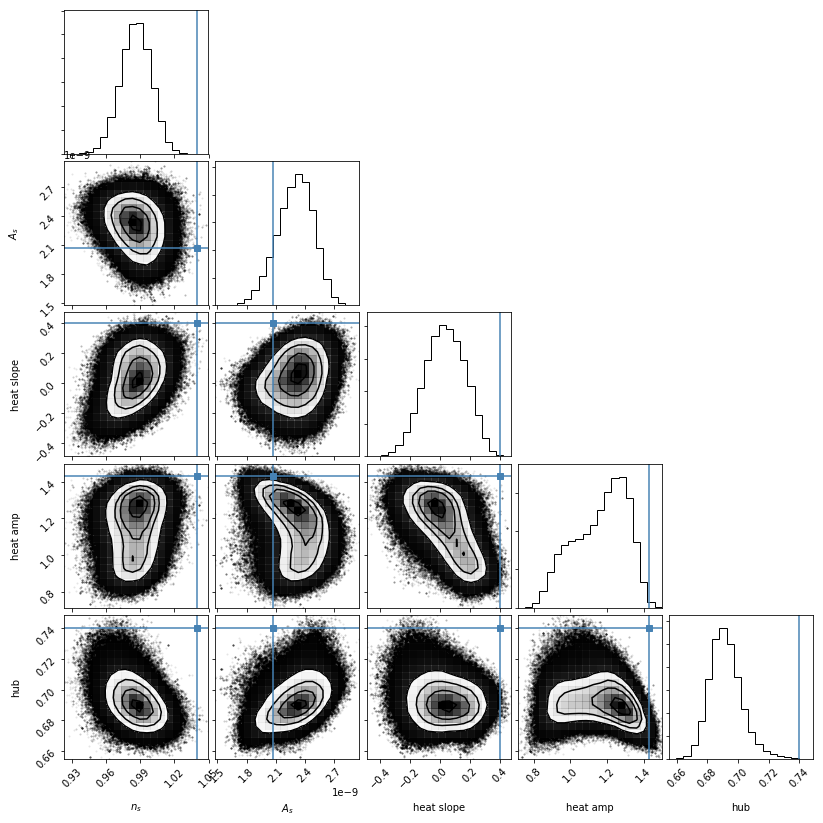

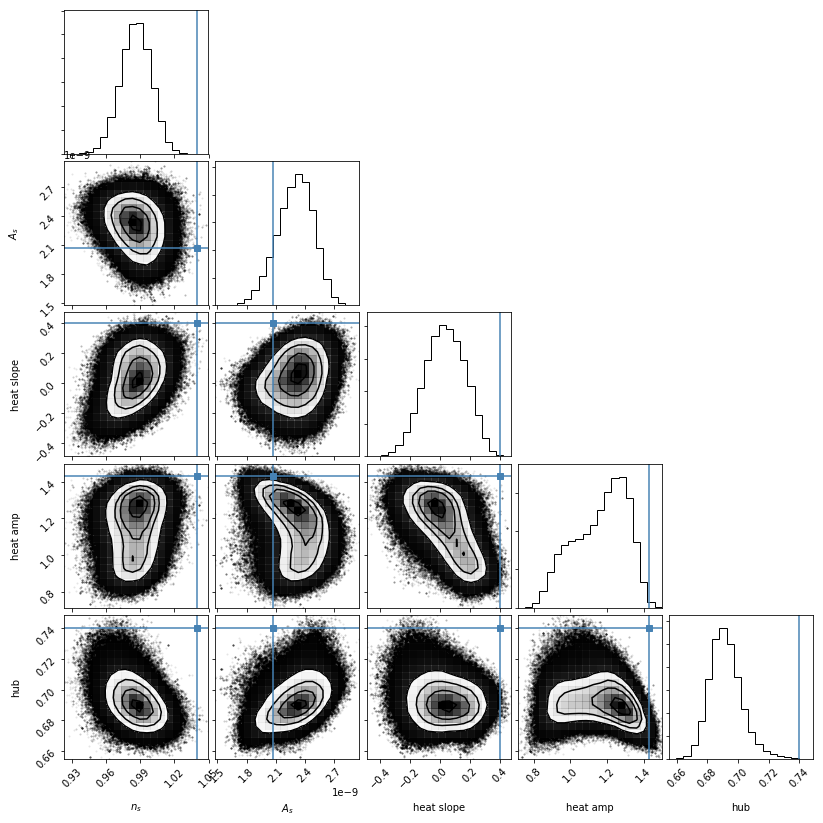

In [12]:
import corner as co

corner_plot_labels = [r'$d\tau_0$', r'$\tau_0$', r'$n_s$', r'$A_s$', 'heat slope', 'heat amp', 'hub']

co.corner(posterior_samples[:, n_marginalised_parameters:], labels=corner_plot_labels[n_marginalised_parameters:], truths=np.concatenate(([], map_from_unit_cube(optimisation_output[best_process].x, output[0].param_limits[n_marginalised_parameters:]))))


In [ ]:
output[0].param_limits

In [ ]:
acquisition_function_tau0_amp = output.make_grid_acquisition_function(1, 2, samples=30000, nu=1., exploitation_weight=0.)
acquisition_function_tau0_amp[acquisition_function_tau0_amp == 0.] = np.nan

In [ ]:
acquisition_function_tau0_amp_exploit = output.make_grid_acquisition_function(0, 2, samples=1000, nu=0., exploitation_weight=1.)
acquisition_function_tau0_amp_exploit[acquisition_function_tau0_amp_exploit == 0.] = np.nan

In [ ]:
plt.contour(np.log10(acquisition_function_tau0_amp).T, 100, extent=[0.75, 1.25, 0.8, 1.2], origin='image')
plt.colorbar()

In [ ]:
plt.imshow(np.exp(acquisition_function_tau0_amp).T, extent=[-0.25, 0.25, 0.8, 1.2])
plt.colorbar()

In [ ]:
plt.figure(figsize=(18, 18))
plt.imshow(np.exp(acquisition_function_tau0_amp_exploit - np.nanmax(acquisition_function_tau0_amp_exploit)).T, extent=[-0.25, 0.25, 0.8, 1.2])
plt.colorbar()
#plt.scatter(0.95, 0.95, color='red')

In [ ]:
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=1., exploitation_weight=0.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.9,]), nu=1., exploitation_weight=0.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([1.,]), nu=1., exploitation_weight=0.)

In [ ]:
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=1., exploitation_weight=1.)
acquisition_function_exploit = output.acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.95,]), nu=0., exploitation_weight=1.)


In [ ]:
output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([0.81,]), nu=1., exploitation_weight=None)


In [ ]:
print(np.mean(output[0]._get_emulator_error_averaged_mean_flux(np.array([0.81,]))))

_ = output[0].likelihood(np.array([0., 0.95, 0.81]))
print(np.mean(output[0].emulated_flux_power_std[0]))

print(np.mean(output[0].emulated_flux_power_std[0]) / np.mean(output[0].emulated_flux_power[0]))

In [ ]:
output.cur_results.flatchain.shape

In [ ]:
output.cur_results.get_lnprob(np.array([0., 0.95, 0.95]))

In [ ]:
print(posterior_samples.shape)

In [ ]:
histogram_output = sb.kdeplot(posterior_samples[:, 2]).get_lines()[0].get_data()

In [ ]:
histogram_output = plt.hist(posterior_samples[:, 2], bins='auto', normed=True, histtype='step', log=True)
print(histogram_output)
plt.axvline(x=0.92)


In [ ]:
print(histogram_output[0].shape)
print(histogram_output[1].shape)
print(histogram_output)

In [ ]:
#n_samples = 200
parameter_samples = (histogram_output[1][:-1] + histogram_output[1][1:]) / 2. #np.linspace(output[0].param_limits[2, 0], output[0].param_limits[2, 1], num=n_samples)
acquisition_function_exploit_array = np.zeros_like(parameter_samples)
for i in range(parameter_samples.shape[0]):
    acquisition_function_exploit_array[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([parameter_samples[i],]), nu=1., exploitation_weight=None)


In [ ]:
#n_samples = 200
parameter_samples2 = histogram_output[0] #np.linspace(output[0].param_limits[2, 0], output[0].param_limits[2, 1], num=n_samples)
acquisition_function_exploit_array2 = np.zeros_like(parameter_samples2)
for i in range(parameter_samples2.shape[0]):
    acquisition_function_exploit_array2[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(np.array([parameter_samples2[i],]), nu=1., exploitation_weight=None)


In [ ]:
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])))
plt.xlim([0.89, 1.11])
plt.ylim([-2.5, 0.1])

In [ ]:
plt.plot(parameter_samples2, 100*acquisition_function_exploit_array2[:parameter_samples2.shape[0]])
plt.axvline(x=0.9, color='black', ls=':')
plt.axvline(x=1., color='black', ls=':')
plt.axvline(x=1.1, color='black', ls=':')
plt.xlim([0.89, 1.11])
plt.ylim([0., 0.2])

In [ ]:
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])), label=r'Exploitation term')
plt.plot(parameter_samples2, 100*acquisition_function_exploit_array2[:parameter_samples2.shape[0]], label=r'Exploration term')
plt.plot(parameter_samples2, np.log(histogram_output[1] / np.max(histogram_output[1])) + 100.*acquisition_function_exploit_array2[:parameter_samples2.shape[0]], label=r'GP-UCB acquisition function')

plt.legend(frameon=False)
#plt.axvline(x=0.9, color='black', ls=':')
plt.axvline(x=0.92, color='blue', ls=':')
plt.axvline(x=0.925, color='green', ls=':')
#plt.axvline(x=0.95, color='black', ls=':')
plt.xlim([0.89, 0.95])
plt.ylim([-0.1, 0.2])
plt.xlabel(r'heat amp')

In [ ]:
output[0].param_limits[0] = np.array([-0.24, 0.24])
print(output[0].param_limits)
output[0].log_likelihood_marginalised_mean_flux(np.array([0.95,]), integration_method='Monte-Carlo', integration_options=6000)


In [ ]:
#output[0].param_limits[0] = np.array([-0.007, 0.007])
#output[0].param_limits[1] = np.array([0.948, 0.952])

integration_bounds = [[-0.08, 0.08], [0.936, 0.964]]

#mmh.dps = 50
integration_instance = mmh.calculus.quadrature.GaussLegendre
print(integration_instance)

likelihood_marginalised = np.zeros(10)
exploration_term = np.zeros_like(likelihood_marginalised)
#parameter_samples = np.linspace(output[0].param_limits[2, 0] + 0.01, output[0].param_limits[2, 1], num=likelihood_marginalised.shape[0], endpoint=False)
parameter_samples = np.linspace(0.912, 0.928, num=likelihood_marginalised.shape[0])
for i in range(likelihood_marginalised.shape[0]):
    parameter_vector = np.array([parameter_samples[i],])
    #likelihood_marginalised[i] = output[0].log_likelihood_marginalised_mean_flux(np.array([parameter_samples[i],]), integration_method='Quadrature', integration_options=integration_instance)
    likelihood_marginalised[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, nu=0., integration_options='gauss-legendre', integration_bounds=integration_bounds)
    exploration_term[i] = output[0].acquisition_function_GP_UCB_marginalised_mean_flux(parameter_vector, exploitation_weight=None, nu=1.e4)


In [ ]:
plt.scatter(parameter_samples, likelihood_marginalised)


In [ ]:
plt.scatter(parameter_samples, likelihood_marginalised - np.nanmax(likelihood_marginalised))
plt.scatter(parameter_samples, exploration_term, color='red')
plt.plot(histogram_output[0], np.log(histogram_output[1] / np.nanmax(histogram_output[1])), color='blue')
plt.axvline(x=0.92)
plt.xlim([0.89, 0.95])
plt.ylim([-0.2, 0.2])

In [ ]:
plt.scatter(parameter_samples, likelihood_marginalised - np.nanmax(likelihood_marginalised), color='red')
#sb.kdeplot(posterior_samples[:, 2])
plt.plot(histogram_output[0], np.log(histogram_output[1] / np.nanmax(histogram_output[1])))
plt.axvline(x=0.92, color='black')
plt.xlim([0.91, 0.93])
plt.ylim([-0.01, 0.01])

In [ ]:
plt.scatter(parameter_samples, np.exp(likelihood_marginalised - np.nanmax(likelihood_marginalised)), color='red')
#sb.kdeplot(posterior_samples[:, 2])
plt.plot(histogram_output[0], histogram_output[1] / np.nanmax(histogram_output[1]))
plt.axvline(x=0.92, color='black')
plt.xlim([0.8, 1.2])

In [ ]:
integration_bounds = [[-0.08, 0.08], [0.936, 0.964]]

acquisition_optimisation = output[0].optimise_acquisition_function(np.array([1.1,]), optimisation_bounds=[(0.81, 1.19),], nu=0., integration_bounds=integration_bounds)


In [ ]:
print(acquisition_optimisation.x)
print(acquisition_optimisation.success)
print(acquisition_optimisation.message)

In [ ]:
parameter_truth = np.array([0., 0.95, 0.975, 2.25e-09, 0.08333333333333326, 0.9166666666666666, 0.6916666666666667])

In [ ]:
optimisation_bounds = [tuple(output[0].param_limits[i]) for i in range(parameter_truth.shape[0])]
print(optimisation_bounds)
optimisation_bounds_unit_cube = [(1.e-7, 1. - 1.e-7) for i in range(parameter_truth.shape[0] - 2)]
print(optimisation_bounds_unit_cube)


In [ ]:
integration_bounds = [[-0.2, 0.2], [0.85, 1.05]]

#parameter_truth = parameter_truth * 1.01
#print(parameter_truth)
#parameter_truth_unit_cube = map_to_unit_cube(parameter_truth, output[0].param_limits)
parameter_truth_unit_cube = 1.e-7 + npr.rand(5) * (1. - 2.e-7)
print(parameter_truth_unit_cube)

def likelihood_function(parameter_vector):
    print(parameter_vector, map_from_unit_cube(parameter_vector, output[0].param_limits[2:]))
    likelihood_evaluation = -1. * output[0].log_likelihood_marginalised_mean_flux(map_from_unit_cube(parameter_vector, output[0].param_limits[2:]), integration_bounds=integration_bounds)
    print(likelihood_evaluation)
    return likelihood_evaluation

#acquisition_optimisation = spo.minimize(likelihood_function, parameter_truth_unit_cube, bounds=optimisation_bounds_unit_cube, options={'disp': True})
acquisition_optimisation = spo.basinhopping(likelihood_function, parameter_truth_unit_cube, minimizer_kwargs={'bounds': optimisation_bounds_unit_cube, 'options': {'disp': True}}, disp=True)

print(acquisition_optimisation.x)
print(acquisition_optimisation.success)
print(acquisition_optimisation.message)

print(map_from_unit_cube(acquisition_optimisation.x, output[0].param_limits[2:]))
#print(map_from_unit_cube(acquisition_optimisation.x, output[0].param_limits) - parameter_truth)

In [ ]:
pool_instance.close()
del pool_instance

n_process = 8

integration_bounds = [[-0.2, 0.2], [0.85, 1.05]]

def likelihood_function(parameter_vector):
    #print(parameter_vector, map_from_unit_cube(parameter_vector, output[0].param_limits[2:]))
    likelihood_evaluation = -1. * output[0].log_likelihood_marginalised_mean_flux(map_from_unit_cube(parameter_vector, output[0].param_limits[2:]), integration_bounds=integration_bounds)
    #print(likelihood_evaluation)
    return likelihood_evaluation

def optimisation_function(optimisation_arguments):
    false_number, parameter_truth_unit_cube = optimisation_arguments

    acquisition_optimisation = spo.minimize(likelihood_function, parameter_truth_unit_cube, bounds=optimisation_bounds_unit_cube, options={'disp': False})
    #print(acquisition_optimisation.success)
    #print(acquisition_optimisation.message)
    return acquisition_optimisation.x
#acquisition_optimisation = spo.basinhopping(likelihood_function, parameter_truth_unit_cube, minimizer_kwargs={'bounds': optimisation_bounds_unit_cube, 'options': {'disp': True}}, disp=True)

optimisation_arguments_list = [(0., 1.e-7 + npr.rand(5) * (1. - 2.e-7)) for i in range(n_process)]
print(optimisation_arguments_list)
pool_instance = mu.Pool(n_process)
optimisation_results = pool_instance.map(optimisation_function, optimisation_arguments_list)


In [ ]:
corner_plot_labels = [r'$n_s$', r'$A_s$', 'heat slope', 'heat amp', 'hub']

co.corner(posterior_samples[:, 2:], labels=corner_plot_labels, truths=np.concatenate(([], map_from_unit_cube(acquisition_optimisation.x, output[0].param_limits[2:]))))


In [ ]:
[-5.86448758e-02  9.64476445e-01  9.88091992e-01  2.40207473e-09
  1.30284380e-01  1.06729539e+00  6.91094030e-01]
[-6.73717605e-02  9.79216137e-01  9.86009810e-01  2.36946453e-09
  1.88449411e-01  9.78980755e-01  6.89627409e-01]
[-7.77305181e-03  9.28751149e-01  9.89338079e-01  2.24040312e-09
 -1.96653971e-02  1.28341469e+00  6.88152784e-01]

In [ ]:
[9.92761335e-01 2.42336688e-09 3.53231102e-02 1.24026185e+00
 6.90070110e-01]
[9.98922713e-01 1.78991408e-09 2.00561918e-01 8.91035270e-01
 7.16109410e-01]
[1.01805673e+00 1.55893077e-09 3.39285232e-01 8.39858390e-01
 7.28723550e-01]
[ 9.76096007e-01  2.27948154e-09 -2.11387489e-01  1.32066491e+00
  6.88386399e-01]

In [ ]:
import numpy as np
from scipy import optimize
from multiprocessing import Pool
import multiprocessing
multiprocessing.set_start_method('forkserver', force=True)
from test_functions import *
#import GPy
#import emcee


#def square(x):
#    print(x)
#    print(np.linalg.pinv(np.eye(2)))
#    return np.sum(x**2+ 2*x)

#def minimize(args):
#    f,x = args
#    res = optimize.minimize(f, x, method = 'L-BFGS-B')
#    return res.x

x = np.random.rand(2,10)

args = [(square, x[i], output[0]) for i in range(2)]
print(args)
p = Pool(2)
p.map(minimize,args)

In [ ]:
import multiprocessing as mg
mg.set_start_method('forkserver', force=True)

import acquisition as ac

n_parameters = 3
n_process = 20

starting_positions = 1.e-7 + npr.rand(n_process, n_parameters - 2) * (1. - 2.e-7)
optimisation_bounds = [(1.e-7, 1. - 1.e-7) for i in range(n_parameters - 2)]
#integration_bounds = [list(output[0].param_limits[0]), list(output[0].param_limits[1])]
integration_bounds = [[-0.005, 0.005], [0.948, 0.952]]
argument_list = [(starting_positions[i], output[0], optimisation_bounds, 0., 1., integration_bounds) for i in range(n_process)]

pool_instance = mg.Pool(n_process)
optimisation_output = pool_instance.map(ac.optimise_acquisition_function_parallel, argument_list)

[print(map_from_unit_cube(optimisation_output[i].x, output[0].param_limits[2:])) for i in range(n_process)]


In [ ]:
[print(optimisation_output[i].fun) for i in range(n_process)]

[print(map_from_unit_cube(starting_positions[i], output[0].param_limits[2:])) for i in range(n_process)]

best_process = np.argmin(np.array([optimisation_output[i].fun for i in range(n_process)]))
print(best_process, map_from_unit_cube(optimisation_output[best_process].x, output[0].param_limits[2:]))

In [ ]:
#from scipy import optimize
#from multiprocessing import Pool
#import multiprocessing
#multiprocessing.set_start_method('forkserver')

n_process = 1
n_total_parameters = 3
n_parameters = 3

output[0].random_function = 1.

class FunctionClass(object):
    def __init__(self):
        pass

    def function_evaluation(self, parameters):
        #return np.sum(parameters**2+ 2*parameters)
        #return output[0].random_function
        print('Evaluating likelihood function')
        tau0_factors = mflux.mean_flux_slope_to_factor(output[0].zout, parameters[0])
        emulator_output = (output[0].gpemu.kf, output[0].gpemu.nk, output[0].gpemu.nz, output[0].gpemu.coreg)
        emulator_output2 = (output[0].gpemu.gps[0].params, output[0].gpemu.gps[0].param_limits, output[0].gpemu.gps[0].intol, output[0].gpemu.gps[0]._test_interp, output[0].gpemu.gps[0].coreg)
        emulator_output3 = (output[0].gpemu.gps[0].scalefactors, output[0].gpemu.gps[0].paramzero)
        parameters_unit_cube = map_to_unit_cube(parameters[1:], output[0].gpemu.gps[0].param_limits)
        numpy_output = np.linalg.pinv(np.eye(2))
        #emulator_output4 = output[0].gpemu.gps[0].gp.optimize(messages=True)
        #.predict(parameters_unit_cube.reshape(1, -1))
        #emulator_output2 = output[0].gpemu.gps[0].predict(parameters[1:].reshape(1, -1))
        #function_predicted, function_std = output[0].gpemu.predict(np.array(parameters[1:]).reshape(1, -1), tau0_factors=tau0_factors)
        #full_output = output[0].likelihood(parameters)
        print('Finished evaluating likelihood function')
        #full_output = output[0].get_BOSS_covariance_single_z(output[0].zout[0])
        #full_output = output[0].
        #print(full_output)
        full_output = 1.
        return np.mean(full_output)

function_class_instance = FunctionClass()

def optimisation_function(parameter_vector):
    print('parameter_vector =', parameter_vector)
    #eturn np.sum(parameter_vector**2+ 2*parameter_vector)
    return function_class_instance.function_evaluation(parameter_vector)
    #return output[0].random_function
    #return -1. * output[0].likelihood(parameter_vector)
    #return -1. * output[0].log_likelihood_marginalised_mean_flux(parameter_vector)

def get_prior_limits():
    #prior_limits = np.ones((5, 2))
    #prior_limits[:, 0] *= -1.5
    #prior_limits[:, 1] *= -0.5
    #return prior_limits
    return output[0].param_limits[n_total_parameters - n_parameters:]

def get_optimisation_function(x):
    print('x in get_optimisation_function =', x)
    #prior_limits = np.ones((5, 2))
    #prior_limits[:, 0] *= -1.5
    #prior_limits[:, 1] *= -0.5
    prior_limits = get_prior_limits()
    x_unscaled = map_from_unit_cube(x, prior_limits)
    print('x_unscaled in get_optimisation_function =', x_unscaled)
    return optimisation_function(x_unscaled)
    #return np.sum(x_unscaled**2+ 2*x_unscaled)
    #return output[0].log_likelihood_marginalised_mean_flux(x_unscaled)

def minimize(args):
    x_bounds = [[1.e-7, 1. - 1.e-7] for i in range(n_parameters)] #For unit hypercube
    f, x = args
    res = spo.minimize(f, x, method = 'L-BFGS-B', bounds=x_bounds, options={'disp': True})
    return res.x

x = 1.e-7 + np.random.rand(n_process, n_parameters) * (1. - 2.e-7) #Starting positions
print('x (starting positions) =', x)

args = [(get_optimisation_function, x[i]) for i in range(n_process)]
p = mu.Pool(n_process)
optimisation_result = p.map(minimize, args)
#optimisation_result = list(map(minimize, args)) #p.
print('optimisation_result =', optimisation_result)

optimisation_result_rescaled = [map_from_unit_cube(optimisation_result[i], get_prior_limits()) for i in range(n_process)]
print('optimisation_result_rescaled =', optimisation_result_rescaled)
print(np.array(optimisation_result) - np.array(x))


In [ ]:
list(map(minimize, args))

In [ ]:
output[0].gpemu.gps

In [ ]:
import sys
print([i for i in locals() if i in sys.modules.keys()])
